# Binary Classification for patient's smoking status
Overview: https://www.kaggle.com/competitions/playground-series-s3e24/overview


## 0) Intro -  Objective 


Your Goal: For this Episode of the Series, your task is to use binary classification to predict a patient's smoking status given information about various other health indicators. Good luck!

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


## 1) Import of packages

In [50]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import QuantileTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)

from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

optuna.logging.set_verbosity(optuna.logging.WARNING)

data/smoking_dataset.csv
data/test.csv
data/test_dataset_original.csv
data/train.csv
data/train_dataset_original.csv


## 1) Load the data and check structure

In [51]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

train_data_original = pd.read_csv("data/train_dataset_original.csv")
test_data_original = pd.read_csv("data/test_dataset_original.csv")

### Original dataset containt smoking status also for the test set above
smoking_data_original = pd.read_csv("data/smoking_dataset.csv",index_col='ID')

print("Shapes before merge", train_data.shape, train_data_original.shape, test_data_original.shape, smoking_data_original.shape)

print("Check data consistency:")
def row_subset(df1, df2):
    return set(map(tuple,df1.to_numpy())).issubset(map(tuple,df2.to_numpy()))

print(row_subset(train_data_original, smoking_data_original.drop(['gender','oral','tartar'],axis=1)))
print(row_subset(test_data_original, smoking_data_original.drop(['gender','oral','tartar','smoking'],axis=1)))

smoking_data_original = smoking_data_original.drop(['gender','oral','tartar'],axis=1)
smoking_data_original = smoking_data_original.drop_duplicates()
print("smoking shape after removing duplicates", smoking_data_original.shape)

### Let's append the original data to this dataset to increse data points
train_data = pd.concat([train_data, smoking_data_original],axis = 0).reset_index(drop=True)
print("Shapes after merge", train_data.shape)


Shapes before merge (159256, 23) (38984, 23) (16708, 22) (55692, 26)
Check data consistency:
True
True
smoking shape after removing duplicates (44552, 23)
Shapes after merge (203808, 23)


#### All numerical variables

In [52]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203808 entries, 0 to 203807
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  203808 non-null  int64  
 1   height(cm)           203808 non-null  int64  
 2   weight(kg)           203808 non-null  int64  
 3   waist(cm)            203808 non-null  float64
 4   eyesight(left)       203808 non-null  float64
 5   eyesight(right)      203808 non-null  float64
 6   hearing(left)        203808 non-null  float64
 7   hearing(right)       203808 non-null  float64
 8   systolic             203808 non-null  float64
 9   relaxation           203808 non-null  float64
 10  fasting blood sugar  203808 non-null  float64
 11  Cholesterol          203808 non-null  float64
 12  triglyceride         203808 non-null  float64
 13  HDL                  203808 non-null  float64
 14  LDL                  203808 non-null  float64
 15  hemoglobin       

#### Original data https://www.kaggle.com/datasets/gauravduttakiit/smoker-status-prediction-using-biosignals

In [53]:
train_data.columns

Index(['age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [54]:
FEATURES = list(set(train_data.columns)-set(["smoking"]))
TARGET = 'smoking'  

## 3) Discover and visualize data to gain insights

##### No missing data

In [55]:
train_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

In [56]:
test_data.isnull().sum()

age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
dtype: int64

In [57]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,203808.0,44.285656,11.896734,20.0,40.0,40.0,55.0,85.0
height(cm),203808.0,165.133606,8.906900,130.0,160.0,165.0,170.0,190.0
weight(kg),203808.0,66.868185,12.649219,30.0,55.0,65.0,75.0,135.0
waist(cm),203808.0,82.799830,9.037021,51.0,76.8,83.0,89.0,129.0
eyesight(left),203808.0,1.007095,0.422422,0.1,0.8,1.0,1.2,9.9
eyesight(right),203808.0,1.002550,0.415314,0.1,0.8,1.0,1.2,9.9
hearing(left),203808.0,1.024332,0.154077,1.0,1.0,1.0,1.0,2.0
hearing(right),203808.0,1.023993,0.153028,1.0,1.0,1.0,1.0,2.0
systolic,203808.0,122.290631,12.951378,71.0,113.0,121.0,130.0,240.0
relaxation,203808.0,76.692470,9.158813,40.0,70.0,77.0,82.0,146.0


Smoking patients are almost half of the train data

In [58]:
train_data.smoking.value_counts()

0    117803
1     86005
Name: smoking, dtype: int64

In [59]:
train_data.smoking.value_counts()[0]

117803

In [60]:
negative_def = train_data.smoking.value_counts()[0]/len(train_data.smoking)
positive_def = 1 - negative_def
class_weights = {0: negative_def, 1: positive_def}
class_weights

{0: 0.5780096953995918, 1: 0.4219903046004082}

### Plot features distribution

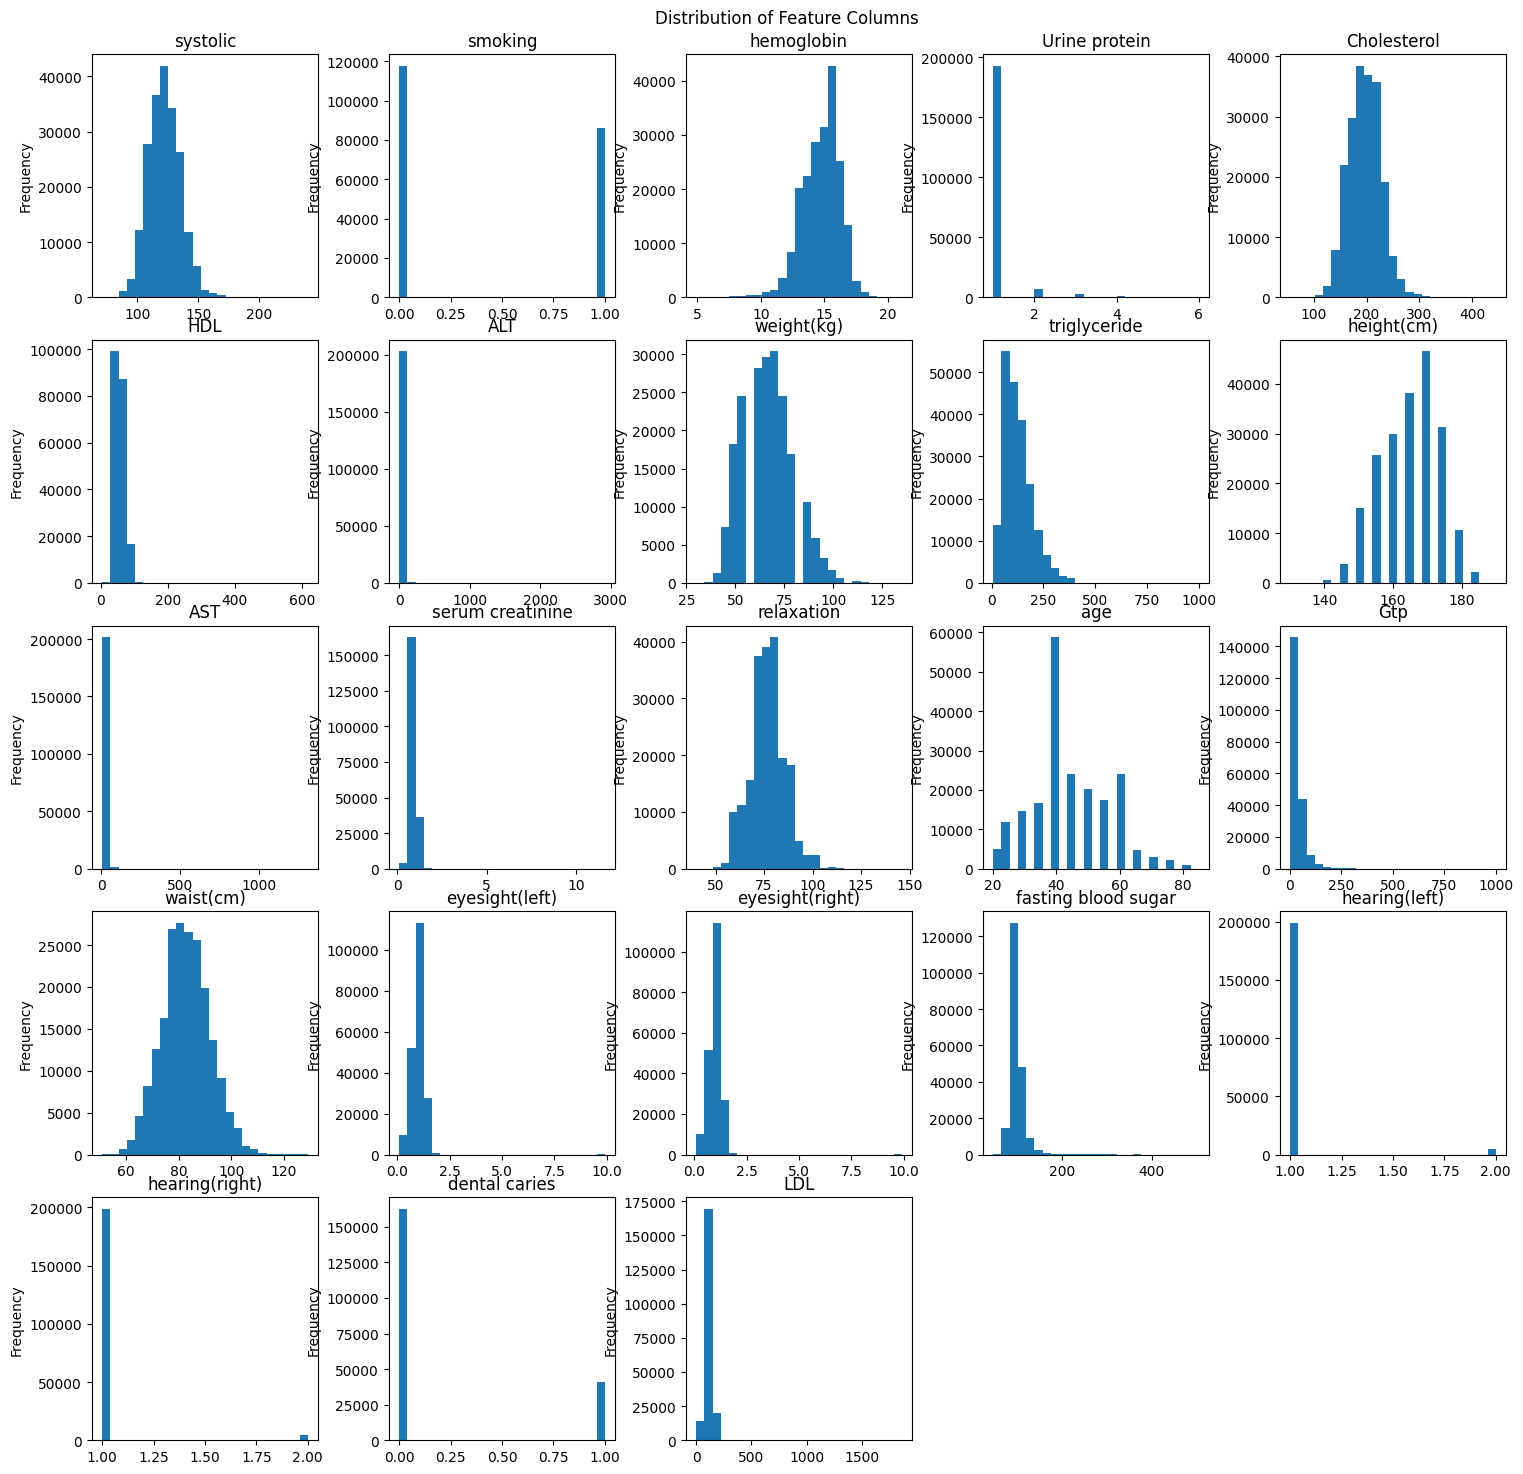

In [61]:
def plot_features_distribution(df):

    feature_columns = set(df.columns)-set(["defects"])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=25, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()

plot_features_distribution(train_data)


### Correlations

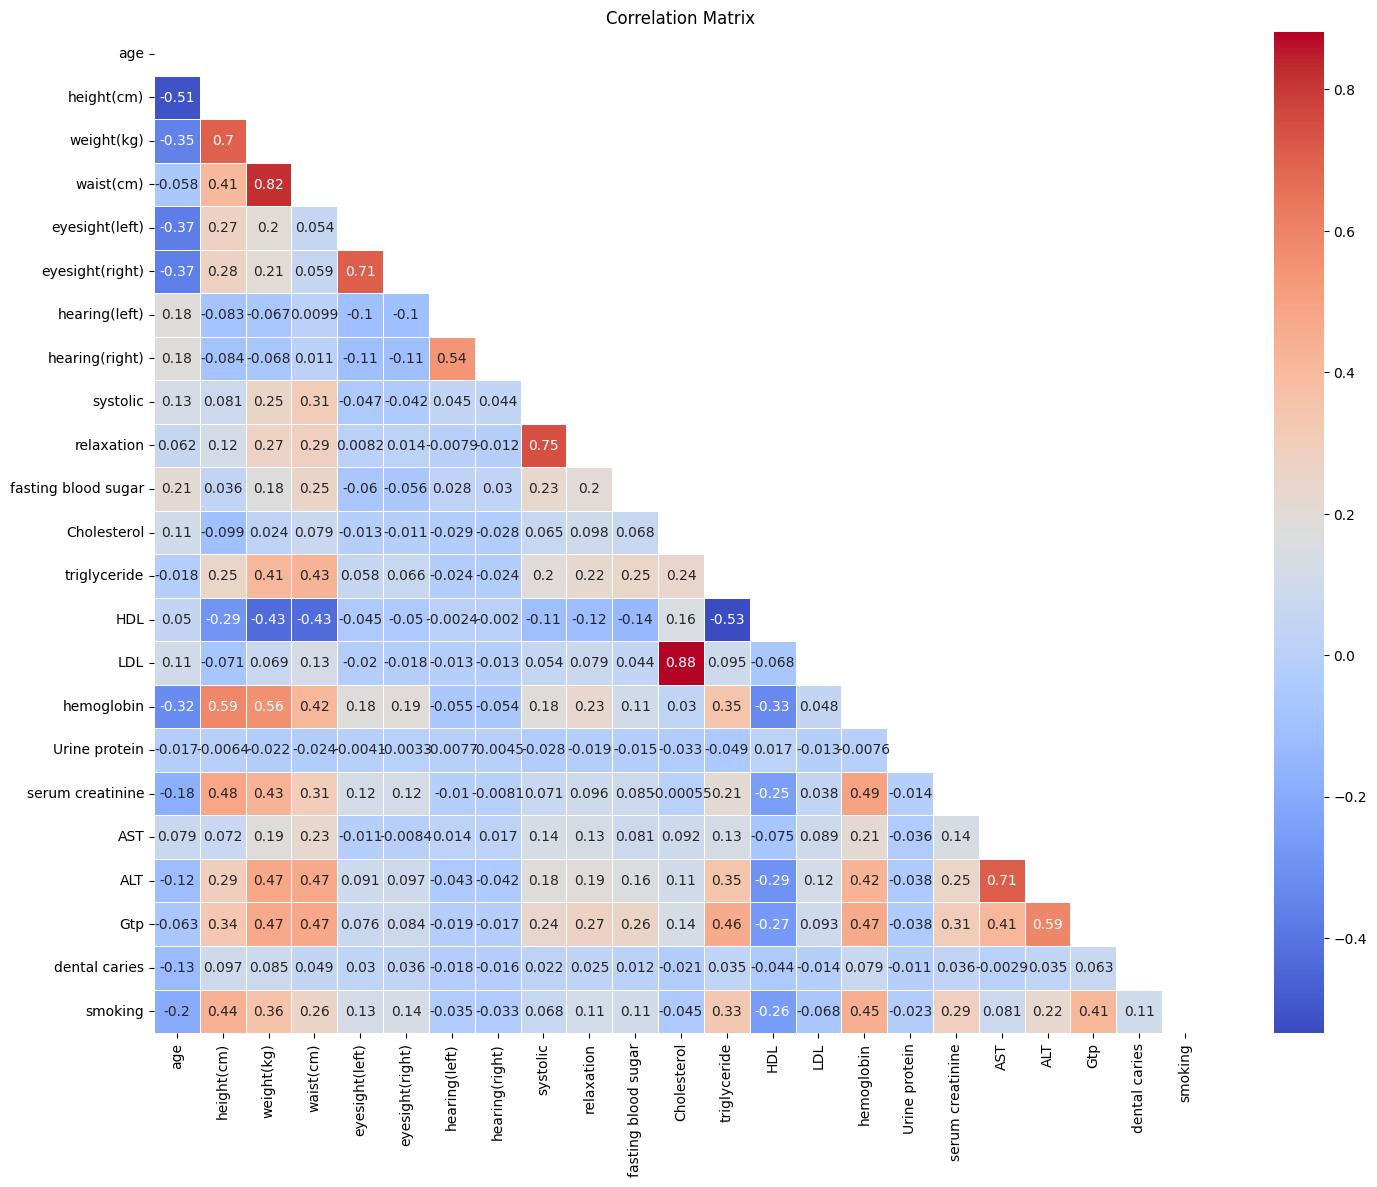

In [62]:
#### Correlation matrix
correlation_matrix = train_data.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Analysis target distribution across features


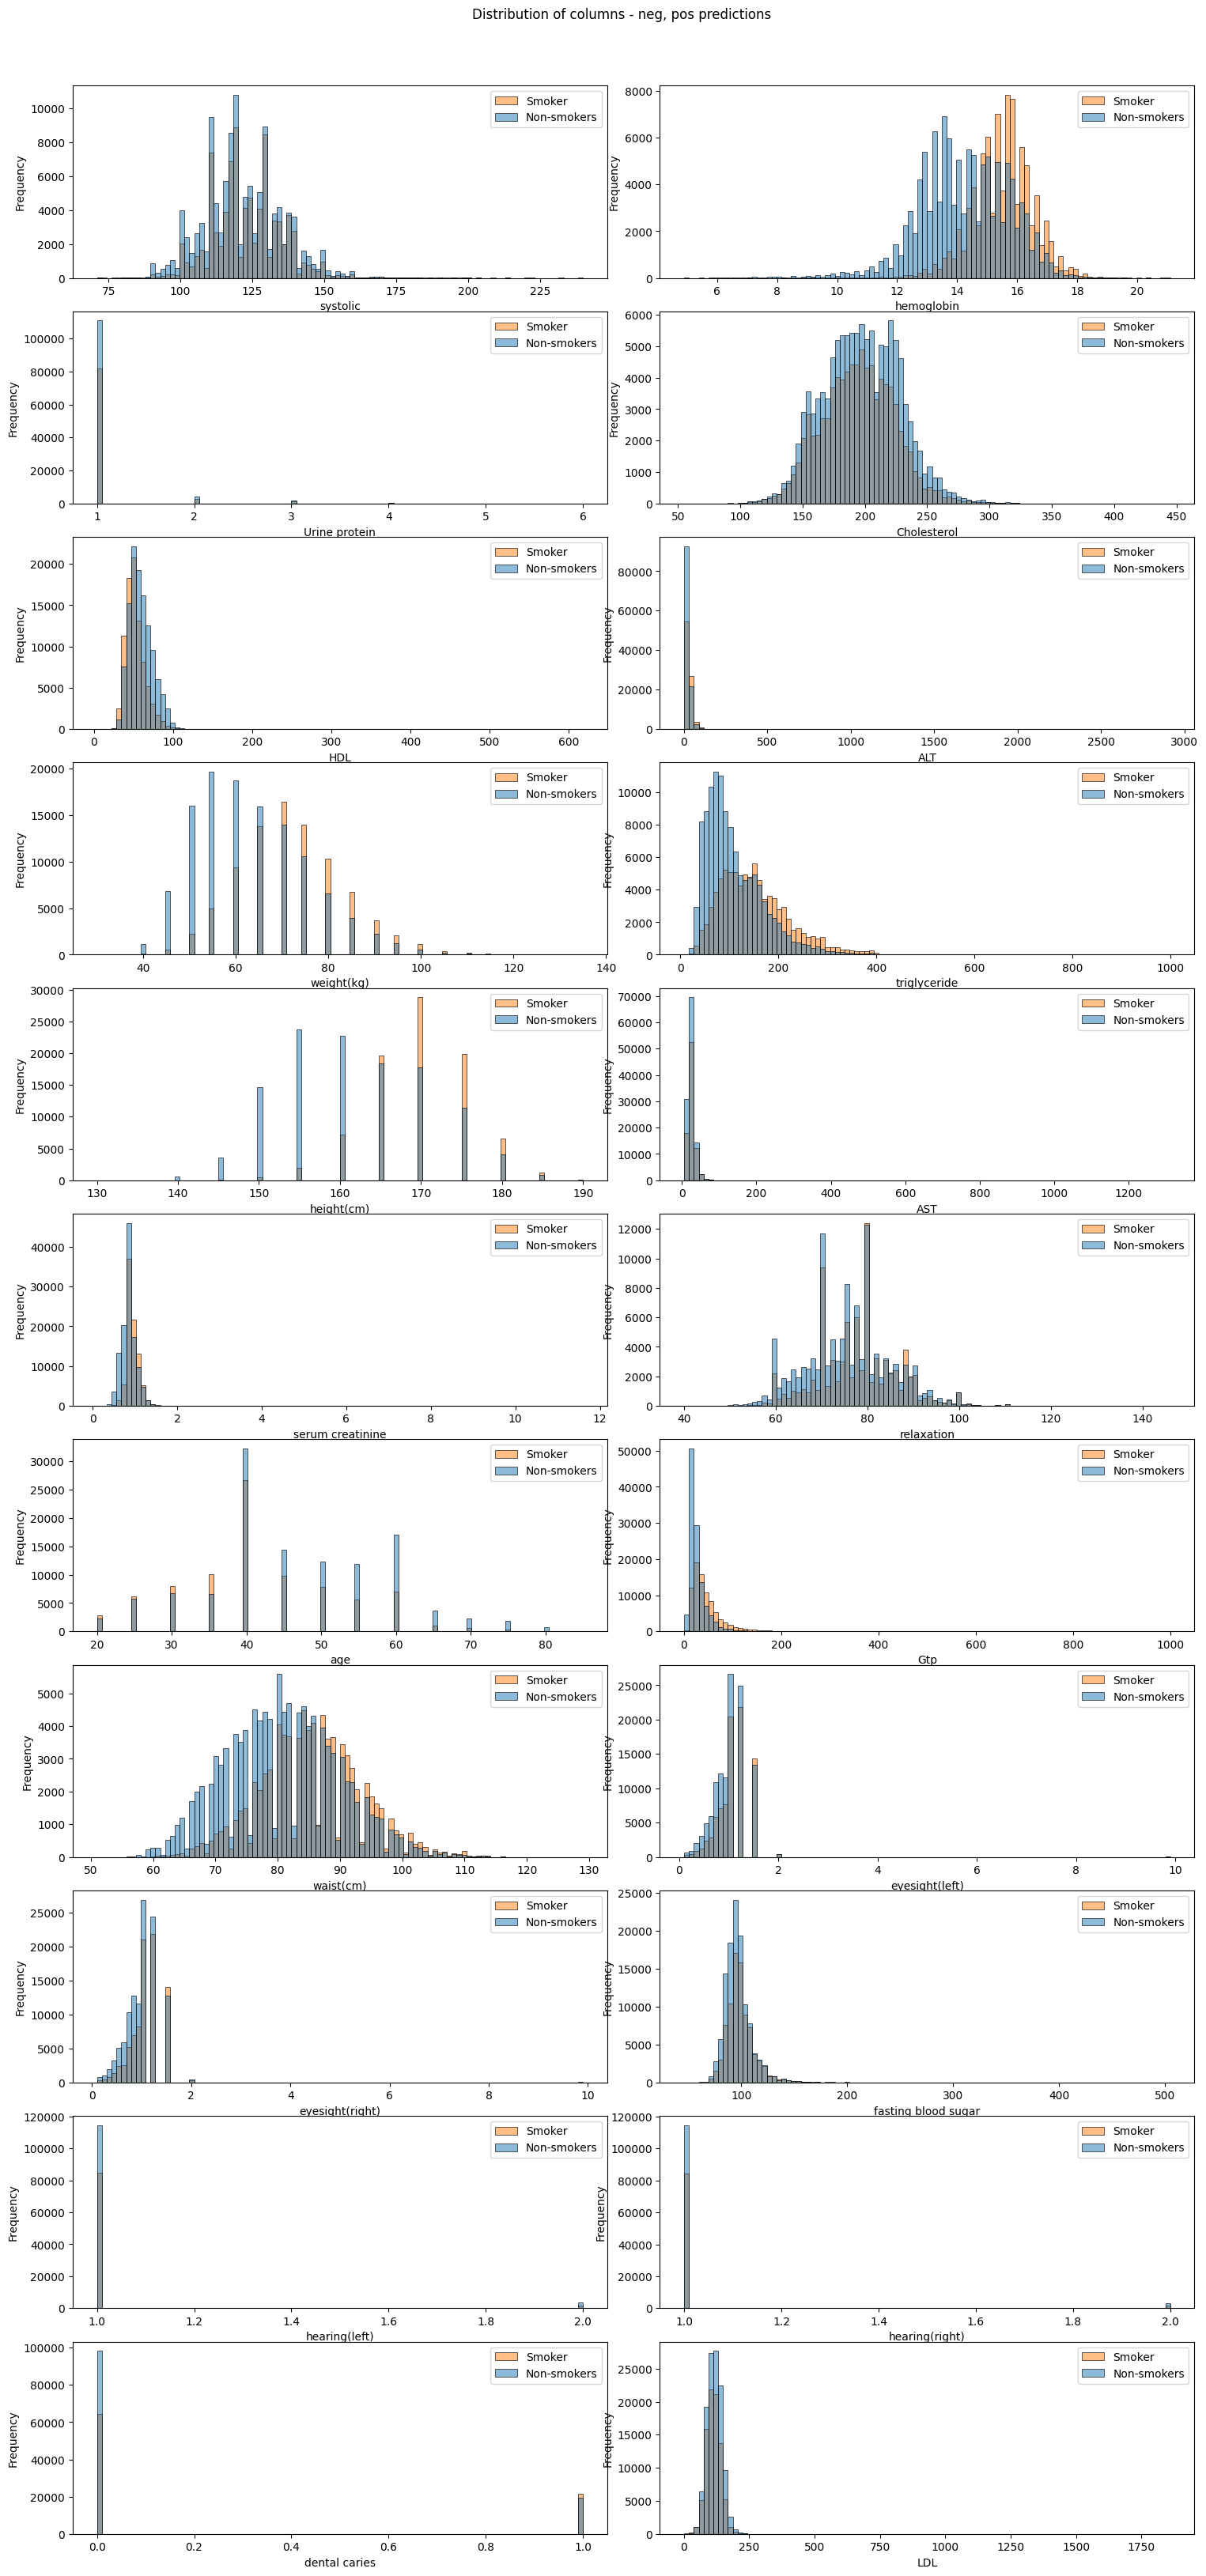

In [63]:
def plot_target_distribution(df, TARGET, FEATURES):

    feature_columns = FEATURES

    negative_pred = df[abs(df[TARGET])<=0.5]
    positive_pred = df[abs(df[TARGET])>0.5]

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 1) // 2
    num_cols = min(len(feature_columns), 2)

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.95, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        # positive_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        # negative_pred[col].plot(kind='hist', ax=ax, bins=100, title=col)
        
        sns.histplot(ax = ax, data = df, x=col, hue=TARGET, element="bars", bins = 100)
        ax.set_ylabel('Frequency')
        ax.legend(['Smoker', 'Non-smokers'])

    # Add a title to the overall picture
    plt.suptitle("Distribution of columns - neg, pos predictions")
    # Show the plot
    plt.show()

plot_target_distribution(train_data, TARGET, FEATURES)

### Observations
Some variables are particularly correlated with smoking:
- height, weight, waist, triglyceride, hemoglobin, Gtp (positively), age and HDL (negatively)
- many variables are normally distributed without transformations
- several variables are binned
- Consider removing highly correlated variables: "Cholesterol", "systolic", "eyesight(right)", "waist(cm)", "AST" or transform them
- There seems to be a strong differences in the distrbutions of smoking/non-smoking for the following features: Hemoglobin, waist, HDL and triglyceride, dental caries
- Gender is an important variable missing here, but present in the original dataset. Its role is partially visible in variables like height and weight (men are on average taller and heavier)

## Feature engineering

#### Let's try to include gender as variable

We use the original dataset to build a model to assign gender given the other variable in this competition dataset

In [66]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate

smoking_data_original = pd.read_csv("data/smoking_dataset.csv",index_col='ID')

kfold = RepeatedStratifiedKFold(n_splits=10,n_repeats=5)
X_0 = smoking_data_original.drop(['gender','oral','tartar','smoking'],axis=1)
y_0 = smoking_data_original['gender'].map({'F':0,'M':1})

results = cross_validate(xgb.XGBClassifier(n_jobs=4,random_state=0),
                         X_0,y_0,
                         scoring='roc_auc',
                         cv=kfold,n_jobs=1,
                         return_estimator=True)

results['test_score'].mean(), results['test_score'].std()


(0.9973703258834307, 0.00043312473093879653)

In [67]:
### Add it back to train and test data
cols = list(test_data_original.columns)

train_data['gender'] = 0
for clf in results['estimator']:
    train_data['gender'] += clf.predict_proba(train_data[cols])[:,1]
train_data['gender'] /= len(results['estimator'])


test_data['gender'] = 0
for clf in results['estimator']:
    test_data['gender'] += clf.predict_proba(test_data[cols])[:,1]
test_data['gender'] /= len(results['estimator'])


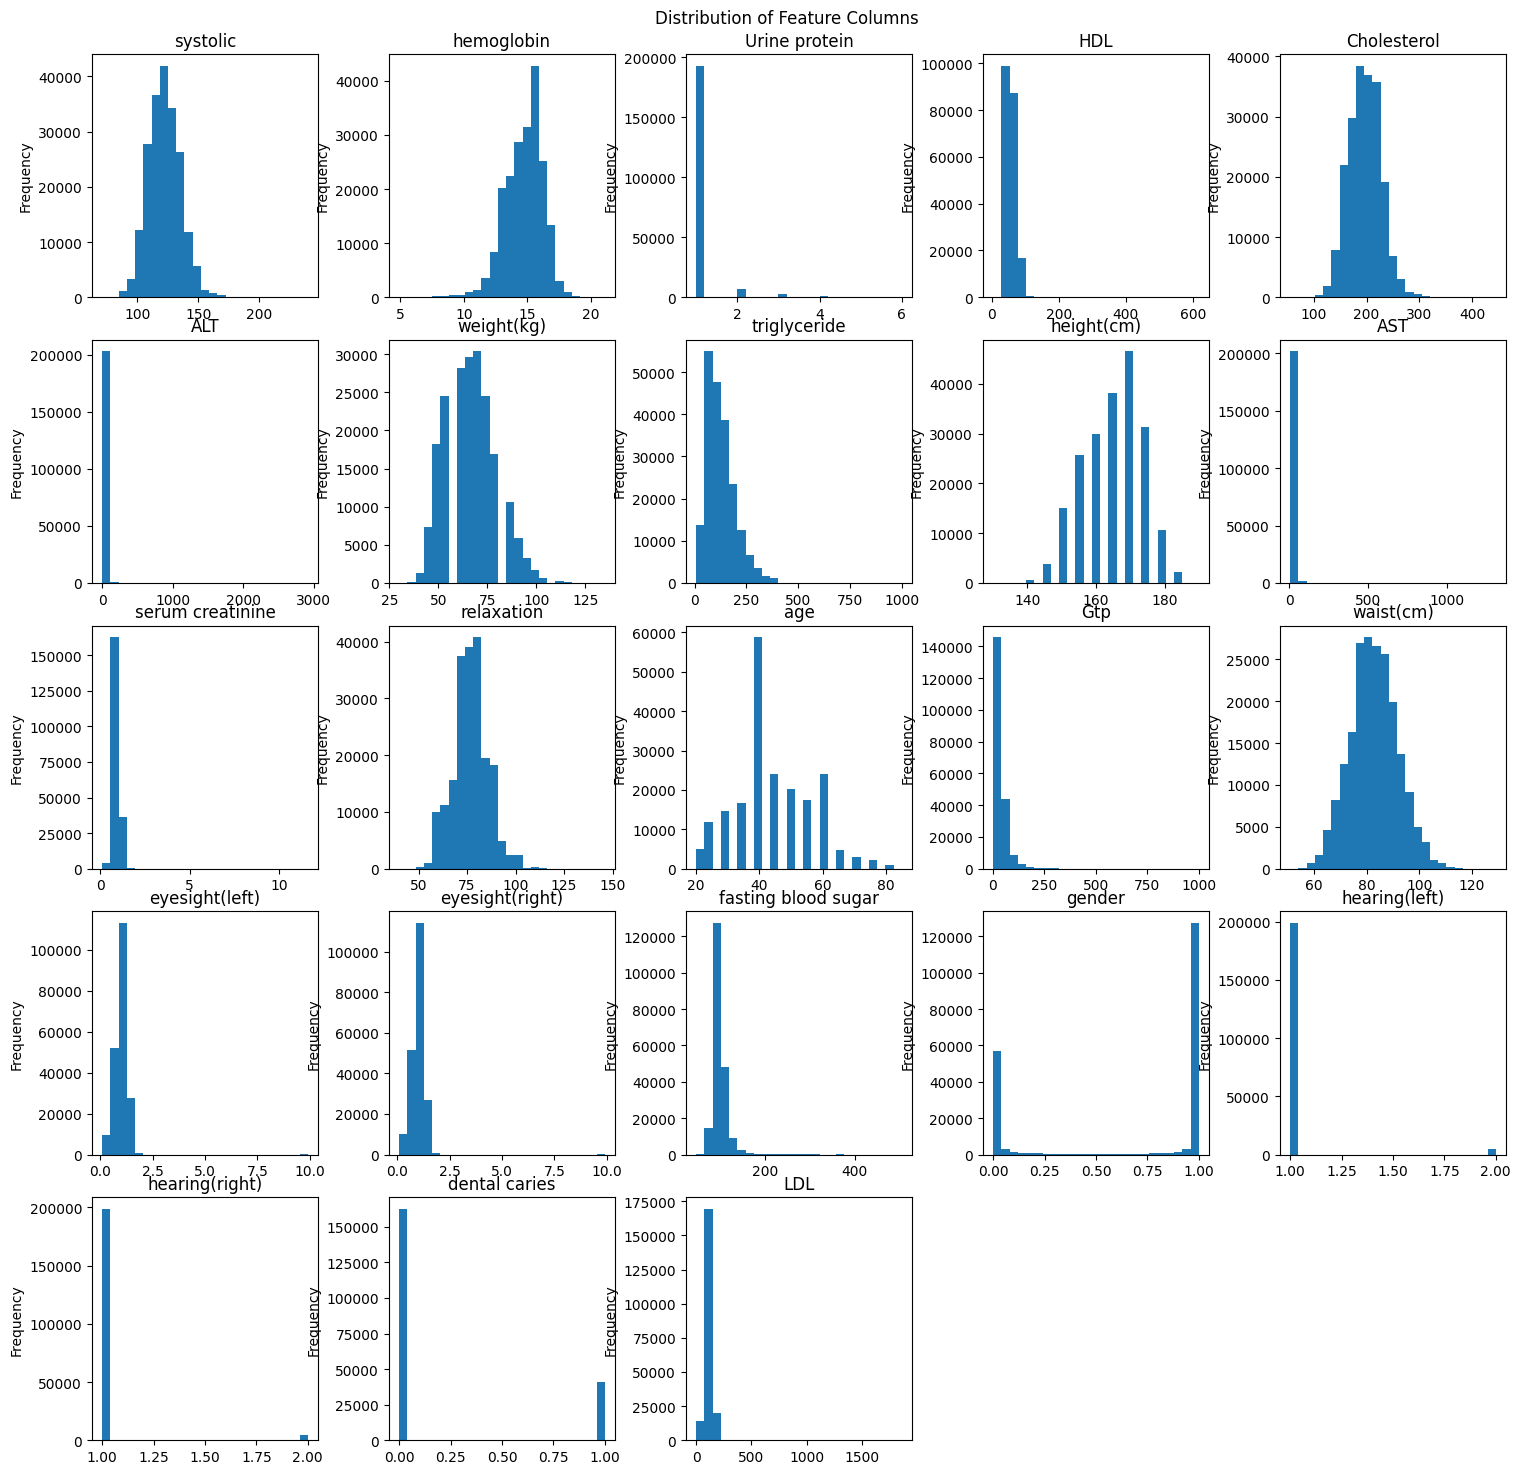

In [68]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import yeojohnson

def edit_X_features(df):

    features_df = df.columns
    df = df.copy()

    # ## Create new features
    df["BMI"] = df['weight(kg)']/(df['height(cm)']/100)**2
    df["HDL-LDL Ratio"] = df["HDL"] / df["LDL"]
    df["Liver Enzyme Ratio"] = df["AST"] / df["ALT"]


    ## Trasform original variables 
    # df = np.sqrt(df)
    # df =  np.log10(df+1)
    # df_new = df_new.apply(lambda x: yeojohnson(x)[0])

    # scaler = MinMaxScaler()
    # scaled_data = scaler.fit_transform(df_new)
    # df_new = pd.DataFrame(scaled_data, columns=df_new.columns,  index=df.index)

    return df

full_enhanced=  edit_X_features(train_data[FEATURES+["gender"]])
plot_features_distribution(full_enhanced)


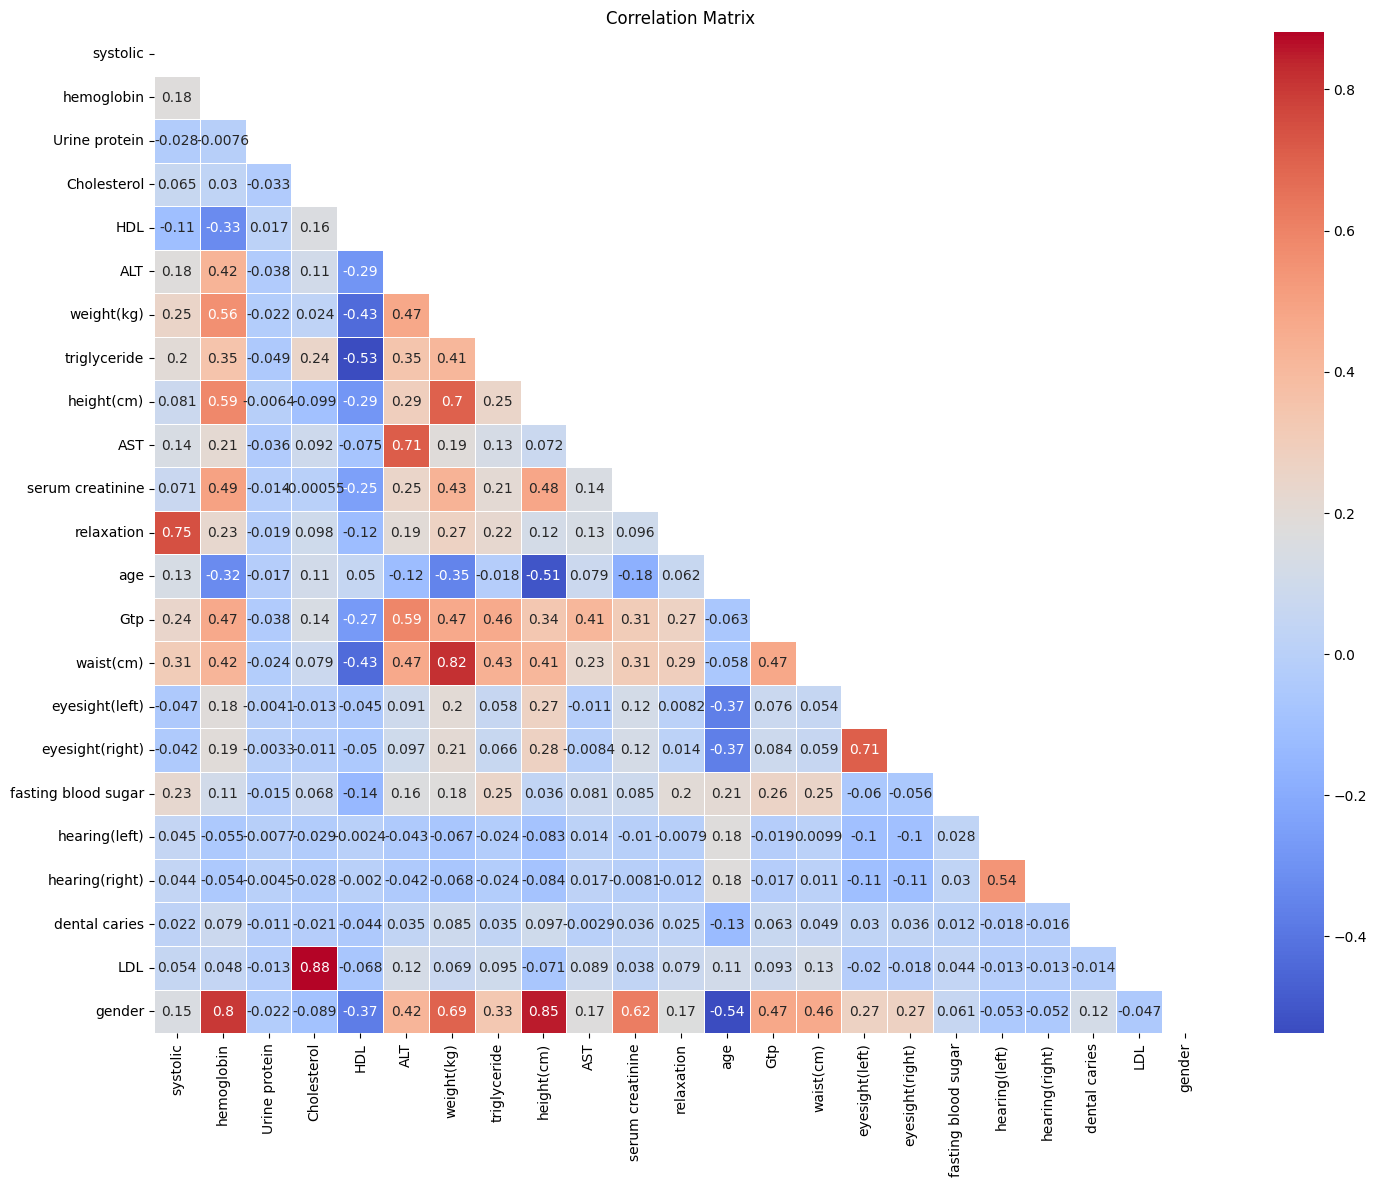

In [69]:
#### Correlation matrix
correlation_matrix = full_enhanced.corr(method="spearman") # To capture non linear correlations
plt.figure(figsize=(17, 13))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [70]:
VARIABLES_TO_REMOVE =  []
FEATURES = list(set(train_data.columns)-set(["smoking"])-set(VARIABLES_TO_REMOVE))
TARGET = 'smoking'  

In [71]:
y = train_data.copy()[TARGET].astype(int)

X_test = test_data[FEATURES].copy()
X = edit_X_features(train_data.copy()[FEATURES])

X_test = edit_X_features(X_test)

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.05,random_state=0)

### Cross validation strategy

In [72]:
nr_folds = 10
kfold = KFold(n_splits=nr_folds,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=nr_folds,shuffle=True,random_state=0)

### Simple logistic regression

In [73]:
def logistic_predictions(train_X, train_y):

    reg = LogisticRegression()
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions_val, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.8150057944146966
ROC-AUC score validation 0.8146641776757408


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### I) XGB Classifier

In [74]:
OPTUNA = False

xgb_params = {'objective':'binary:logistic', 
              'n_estimators':1000,
              'learning_rate':0.05079193283094108,
              'colsample_bytree':0.5,
              'tree_method':'hist',
              'max_depth':None,
              'gamma':0,
            #   'scale_pos_weight':negative_def/positive_def,
              'random_state':0}

# xgb_params = {'objective':'binary:logistic', 
#               'n_estimators':1000,
#               'learning_rate':0.05,
#               'colsample_bytree':0.5,
#               'tree_method':'hist',
#               'max_depth':None,
#               'gamma':0,
#             #   'scale_pos_weight':negative_def/positive_def,
#               'random_state':0}

def XGBoost_predictions(train_X, train_y, val_X, val_y, xgb_params, optuna):

    reg = xgb.XGBClassifier(eval_metric  = "mape", **xgb_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc


if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':trial.suggest_int('n_estimators',50,1000),
                  'learning_rate':trial.suggest_float('learning_rate',0.03,0.3),
                  'tree_method':'hist',
                  'max_depth':None,
                  'gamma':trial.suggest_int('gamma',0,15),
                #   'scale_pos_weight':negative_def/positive_def,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            xgb_predictions_fold, xgb_model_fold, xgb_val_auc_fold = XGBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            xgb_auc_score_avg += xgb_val_auc_fold
            
        xgb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=100, show_progress_bar=True, n_jobs=10)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)


if OPTUNA == True:
    xgb_params = best_xgb_params

xgb_predictions_val, xgb_model, xgb_val_auc = XGBoost_predictions(train_X, train_y,val_X, val_y, xgb_params, False)
#xgb_model.score


ROC-AUC score training 0.9059943930149599
ROC-AUC score validation 0.8687606112054329


### II) Random forest classifier

In [41]:
# OPTUNA = False

# rf_params = { 'n_estimators':883,
#               'max_depth':14,
#               'min_samples_split':5,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

# # rf_params = { 'n_estimators':935,
# #               'max_depth':10,
# #               'min_samples_split':3,
# #               'class_weight':class_weights,
# #               'random_state':0,
# #               'bootstrap':True,
# #               'n_jobs' :-1}

# def RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, optuna):

#     reg = RandomForestClassifier(**rf_params)
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def rf_objective(trial):

#         # Set the hyperparameters of the Random forest classifier.
#         params = {'n_estimators':trial.suggest_int('n_estimators',200,1000),
#               'max_depth':trial.suggest_int('max_depth',1,15),
#               'min_samples_split':trial.suggest_int('min_samples_split',2,7),
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':True,
#               'n_jobs' :-1}

#         rf_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             rf_predictions_fold, rf_model_fold, rf_val_auc_fold = RandomForest_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
#             rf_auc_score_avg += rf_val_auc_fold
            
#         rf_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -rf_auc_score_avg

#     rf_study = optuna.create_study()
#     rf_study.optimize(rf_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_rf_params = rf_study.best_trial.params

#     print('Best RF hyper parameters:', best_rf_params)

# if OPTUNA == True:
#     rf_params = best_rf_params

# random_forest_predictions_val, rf_model, rf_val_auc = RandomForest_predictions(train_X, train_y, val_X, val_y, rf_params, False)

### III) ExtraTreesClassifier

In [42]:
# OPTUNA = False

# # et_params = { 'n_estimators':993,
# #               'max_depth':99,
# #               'max_features':'auto',
# #               'min_samples_split':10,
# #               'min_samples_leaf':1,
# #               'class_weight':class_weights,
# #               'random_state':0,
# #               'bootstrap':False,
# #               'n_jobs' :-1}

# et_params = { 'n_estimators':1000,
#               'max_depth':16,
#               'max_features':'auto',
#               'min_samples_split':9,
#               'min_samples_leaf':3,
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':False,
#               'n_jobs' :-1}

# def ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, optuna):

#     reg = ExtraTreesClassifier(**et_params)
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc


# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def extratree_objective(trial):

#         # Set the hyperparameters of the Random forest classifier.
#         params = {'n_estimators':trial.suggest_int('n_estimators',100,1000),
#               'max_depth':trial.suggest_int('max_depth',1,100),
#               'max_features':'auto',
#               'min_samples_split':trial.suggest_int('min_samples_split',2,10),
#               'min_samples_leaf':trial.suggest_int('min_samples_leaf',1,10),
#               'class_weight':class_weights,
#               'random_state':0,
#               'bootstrap':False,
#               'n_jobs' :-1}
        
#         et_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             et_predictions_fold, et_model_fold, et_val_auc_fold = ExtraTrees_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
#             et_auc_score_avg += et_val_auc_fold
            
#         et_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -et_auc_score_avg

#     et_study = optuna.create_study()
#     et_study.optimize(extratree_objective, n_trials=20, n_jobs=10, show_progress_bar=True)
#     best_et_params = et_study.best_trial.params

#     print('Best Extratree hyper parameters:', best_et_params)

# if OPTUNA == True:
#     et_params=best_et_params
    
# extratree_classifier_predictions_val, extratree_model, extrateree_val_auc = ExtraTrees_predictions(train_X, train_y, val_X, val_y, et_params, False)

### IV) Logistic regression with Nyström kernel approximation

In [43]:
# OPTUNA = False
# nystroem_params = {'n_components':2000}

# def nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, optuna):

#     # Standardize the features (optional but recommended)
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(train_X)
#     X_test = scaler.transform(val_X)

#     # Create a Nystroem feature map
#     nystroem = Nystroem(kernel='rbf', **nystroem_params, random_state=42)

#     # Apply the feature map to both the training and testing data
#     X_train_nystroem = nystroem.fit_transform(X_train)
#     X_test_nystroem = nystroem.transform(X_test)

#     # Create and train the logistic regression model
#     reg = LogisticRegression()
#     reg.fit(X_train_nystroem, train_y)

#     # Make predictions on the test set
#     predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(X_test_nystroem)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         X_train_nystroem_full = nystroem.fit_transform(pd.concat([train_X, val_X]))
#         reg.fit(X_train_nystroem_full,pd.concat([train_y, val_y]))

#     return predictions, reg, val_auc

# if OPTUNA:
#     # Use optuna library for optimizing multiple hyper parameters
#     def nystroem_objective(trial):
#         params = {'n_components':trial.suggest_int('n_components',50,500)}        
        
#         ny_auc_score_avg = 0
#         for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            
#             print("Running fold ", idx)
#             train_X_fold = X.iloc[train_idx]
#             val_X_fold = X.iloc[val_idx]
#             train_y_fold = y[train_idx]
#             val_y_fold = y[val_idx]

#             ny_predictions_fold, ny_model_fold, ny_val_auc_fold = nystroem_logistic(train_X_fold, train_y_fold, val_X_fold, val_y_fold, params, True)
#             ny_auc_score_avg += ny_val_auc_fold
            
#         ny_auc_score_avg /=nr_folds
#         # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
#         return -ny_auc_score_avg

#     ny_study = optuna.create_study()
#     ny_study.optimize(nystroem_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
#     best_ny_params = ny_study.best_trial.params

#     print('Best nystroem logistic hyper parameters:', best_ny_params)

# if OPTUNA ==True:
#     nystroem_params=best_ny_params
    
# # nystroem_params = best_ny_params
# nystroem_logistic_predictions_val, nystroem_logistic_model, nystroem_val_auc_fold = nystroem_logistic(train_X, train_y, val_X, val_y, nystroem_params, False)

### V) CatBoostClassifier

In [75]:
OPTUNA = False

cb_params = {'iterations': 1250,
            'depth': 6,
            'learning_rate': 0.10220287159013668,
            'l2_leaf_reg': 1,
            'loss_function':'Logloss',
            'verbose':0,
            'random_seed':42,
            'class_weights':class_weights
            }

def CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, optuna):

    reg = CatBoostClassifier(**cb_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def catboost_objective(trial):

        # Set the hyperparameters of the Random forest classifier.

        params = {'iterations':trial.suggest_int('iterations',500, 2000),
              'depth':trial.suggest_int('depth',1,10),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'l2_leaf_reg':trial.suggest_int('l2_leaf_reg',1,10),
              'loss_function':'Logloss',
              'verbose':0,
              'random_seed':42,
              'class_weights':class_weights
              }
        
        cb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            cb_predictions_fold, cb_model_fold, cb_val_auc_fold = CatBoost_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            cb_auc_score_avg += cb_val_auc_fold
            
        cb_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -cb_auc_score_avg

    cb_study = optuna.create_study()
    cb_study.optimize(catboost_objective, n_trials=50, n_jobs=10, show_progress_bar=True)
    best_cb_params = cb_study.best_trial.params

    print('Best catboost hyper parameters:', best_cb_params)

if OPTUNA == True:
    cb_params=best_cb_params

catbost_classifier_predictions_val, catboost_model, catboost_val_auc = CatBoost_predictions(train_X, train_y, val_X, val_y, cb_params, True)

ROC-AUC score training 0.9013273446127276
ROC-AUC score validation 0.8675597217688151


#### Feature importance

Text(0.5, 1.0, 'Feature Importance')

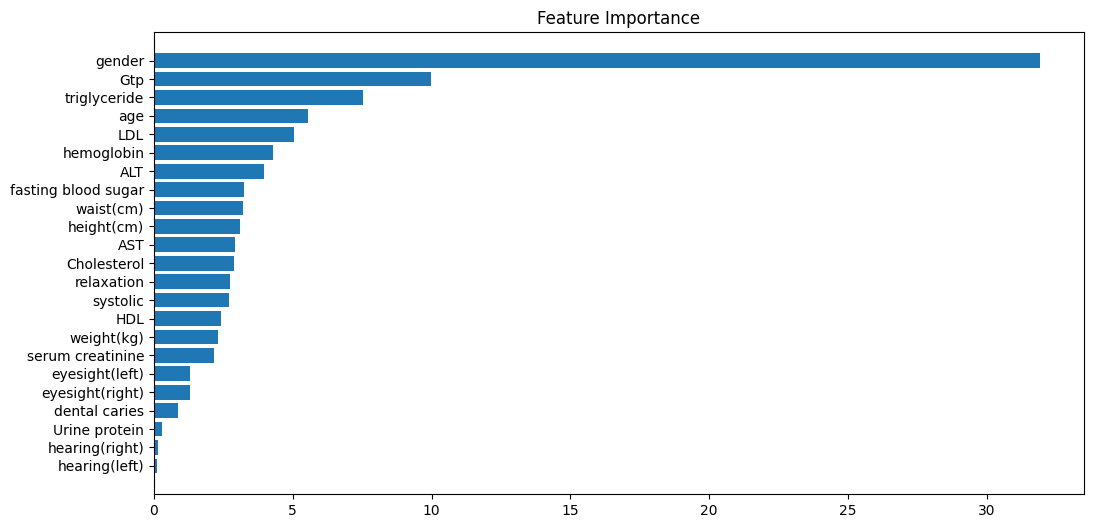

In [76]:
feature_importance = catboost_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')


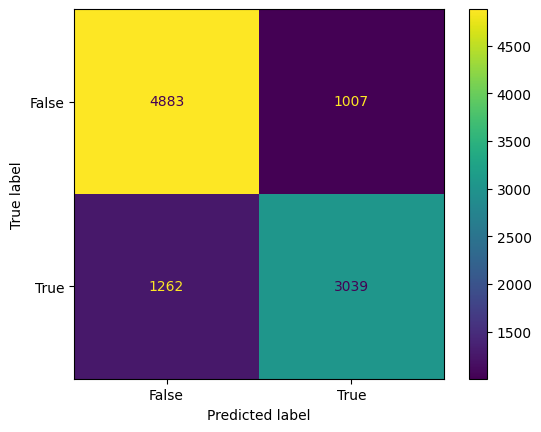

In [77]:
predictions_conf = [0 if x < 0.5 else 1 for x in catbost_classifier_predictions_val]
predictions_conf

confusion_matrix = metrics.confusion_matrix(val_y, predictions_conf)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

### VI) LGBMClassifier

In [78]:
OPTUNA = False

lgbm_params = {'boosting_type':'gbdt',
              'num_leaves':108,
              'learning_rate':0.02116145429539354,
              'n_estimators':1653,
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }

def lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, optuna):

    reg = lgb.LGBMClassifier(**lgbm_params)    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def lgbm_objective(trial):

        # Set the hyperparameters of the Random forest classifier.    
        params = { 'boosting_type':'gbdt',
              'num_leaves':trial.suggest_int('num_leaves',10, 200),
              'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
              'n_estimators':trial.suggest_int('n_estimators',100, 2000),
              'max_depth':-1,
              'random_state':42,
              'class_weight':class_weights
              }
        
        lgbm_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            lgbm_predictions_fold, lgbm_model_fold, lgbm_val_auc_fold = lgbm_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            lgbm_auc_score_avg += lgbm_val_auc_fold
            
        lgbm_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -lgbm_auc_score_avg

    lgbm_study = optuna.create_study()
    lgbm_study.optimize(lgbm_objective, n_trials=10, n_jobs=10, show_progress_bar=True)
    best_lgbm_params = lgbm_study.best_trial.params

    print('Best lgbm hyper parameters:', best_lgbm_params)

if OPTUNA == True:
    lgbm_params = best_lgbm_params

lgbm_classifier_predictions_val, lgbm_model, lgbm_val_auc= lgbm_predictions(train_X, train_y, val_X, val_y, lgbm_params, False)

ROC-AUC score training 0.9446003404253495
ROC-AUC score validation 0.8672246632737126


### VII) HistGradientBoostingClassifier

In [79]:
OPTUNA = False
hgbc_params =  {'max_iter': 800, 
                'learning_rate': 0.10,#0.12079596267303279, 
                'max_depth': 4, 
                'l2_regularization': 0.02, #0.06731258939148825, 
                'random_state':42}

def hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, optuna):

    reg = HistGradientBoostingClassifier(**hgbc_params)
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    val_auc = roc_auc_score(val_y,predictions)

    if optuna == False:
        # for the final prediction, fit model on train + validation set
        reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))

    return predictions, reg, val_auc

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def hgbc_objective(trial):

        # Set the hyperparameters of the Random forest classifier.
           
        params = {
            'max_iter':trial.suggest_int('max_iter',1, 1000),
            'learning_rate':trial.suggest_float('learning_rate',0.01,0.3),
            'max_depth':trial.suggest_int('max_depth',1, 100),
            'random_state':42,
            'l2_regularization':trial.suggest_float('l2_regularization',0, 0.1),
              }
        
        hgbc_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):

            print("Running fold ", idx)
            train_X_fold = X.iloc[train_idx]
            val_X_fold = X.iloc[val_idx]
            train_y_fold = y[train_idx]
            val_y_fold = y[val_idx]

            hgbc_predictions_fold, hgbc_model_fold, hgbc_val_auc_fold = hgbc_predictions(train_X_fold, train_y_fold,val_X_fold, val_y_fold, params, True)
            hgbc_auc_score_avg += hgbc_val_auc_fold
            
        hgbc_auc_score_avg /=nr_folds
        # print(f'The averaged AUC score evaluated on the validation subset using RF model:', rf_auc_score_avg)
        return -hgbc_auc_score_avg

    hgbc_study = optuna.create_study()
    hgbc_study.optimize(hgbc_objective, n_trials=50, n_jobs=10, show_progress_bar=True)
    best_hgbc_params = hgbc_study.best_trial.params

    print('Best hgbc hyper parameters:', best_hgbc_params)

if OPTUNA==True:
    hgbc_params = best_hgbc_params

hgbc_classifier_predictions_val, hgbc_model, hgbc_val_auc = hgbc_predictions(train_X, train_y, val_X, val_y, hgbc_params, False)

ROC-AUC score training 0.8800108851785702
ROC-AUC score validation 0.8656075560269674


### VIII) Neural network

In [49]:
# nn_params =  {"hidden_layer_sizes":(20, 10, 5), 
#               "activation":'relu', 
#               "max_iter":100, 
#               "random_state":42}

# def neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, optuna):
#     # Create an MLPClassifier (Multi-layer Perceptron) neural network
#     # You can customize the architecture by adjusting the hidden_layer_sizes and other parameters.
#     reg = MLPClassifier(**nn_params)

#     # Train the model
#     reg.fit(train_X,train_y)

#     predictions_train = reg.predict_proba(train_X)[:,1]
#     predictions_train[predictions_train>1]=1
#     predictions_train[predictions_train<0]=0
#     print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

#     predictions = reg.predict_proba(val_X)[:,1]
#     predictions[predictions>1]=1
#     predictions[predictions<0]=0
#     print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

#     val_auc = roc_auc_score(val_y,predictions)

#     if optuna == False:
#         # for the final prediction, fit model on train + validation set
#         reg.fit(pd.concat([train_X, val_X]),pd.concat([train_y, val_y]))
    
#     return predictions, reg, val_auc

# nn_classifier_predictions_val, nn_model, nn_val_auc = neural_network_classifier(train_X, train_y, val_X, val_y, nn_params, False)

## Check AUC-ROC

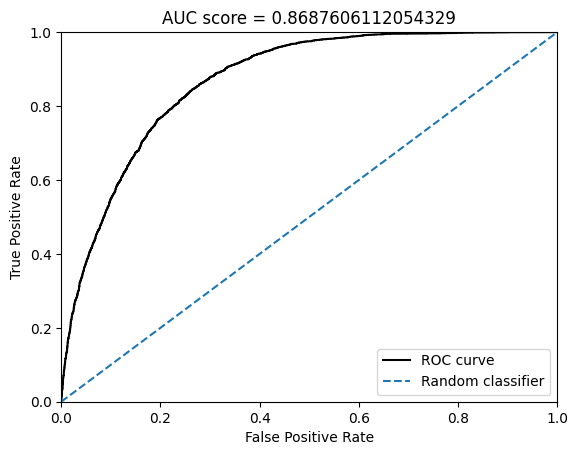

In [80]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_predictions_val)
# plot_roc(val_y,random_forest_predictions)
# plot_roc(val_y,extratree_classifier_predictions)
# plot_roc(val_y,log_predictions)

### Rank models by performance

In [81]:
val_predictions_roc = {'xgb':roc_auc_score(val_y,xgb_predictions_val),
                    #    'rf':roc_auc_score(val_y,random_forest_predictions_val),
                     # 'extratree':roc_auc_score(val_y,extratree_classifier_predictions_val),
                       'log':roc_auc_score(val_y,log_predictions_val),
                       'lgbm':roc_auc_score(val_y,lgbm_classifier_predictions_val),
                       'catboost':roc_auc_score(val_y,catbost_classifier_predictions_val),
                       'hgbc':roc_auc_score(val_y,hgbc_classifier_predictions_val),
                    #    'nystroem':roc_auc_score(val_y,nystroem_logistic_predictions_val),     
                    #    'neural':roc_auc_score(val_y,nn_classifier_predictions_val),     
                       }

val_predictions_roc = sorted(val_predictions_roc.items(), key=lambda x:x[1],  reverse=True)
val_predictions_roc


[('xgb', 0.8687606112054329),
 ('catboost', 0.8675597217688151),
 ('lgbm', 0.8672246632737126),
 ('hgbc', 0.8656075560269674),
 ('log', 0.8146641776757408)]

### Optimize weights for the ensamble with Optuna (on initial validation set)

In [82]:
# ensamble_weights = [0.25, 0.25, 0.00, 0.25, 0.25, 0.00, 0.00, 0.00] # manual version
ensamble_weights = [0.40, 0.20, 0.20, 0.20] # manual version

'''
model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val,
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val, random_forest_predictions_val,
                            extratree_classifier_predictions_val, nn_classifier_predictions_val]
'''

model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, 
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val,
                            ]

ensamble_predictions_val = np.average(model_predictions_val, weights=ensamble_weights, axis=0)
roc_auc_score(val_y,ensamble_predictions_val)

0.8691444995024256

In [83]:
if True:

  optuna.logging.set_verbosity(optuna.logging.WARNING)

  def ensamble_objective(trial):
    STEP_SIZE = 2

    weights = []
    all_models_predictions = []

    # we'll use a variable for setting upper limit for suggested value
    # since we intend to update it after each weight suggestion
    upper_limit = 100

    w_xgb = trial.suggest_int("w_xgb", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_xgb)

    upper_limit -= w_xgb
    upper_limit = upper_limit

    w_catboost = trial.suggest_int("w_catboost", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_catboost)

    upper_limit -= w_catboost
    upper_limit = upper_limit

    # w_nystroem = trial.suggest_int("w_nystroem", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_nystroem)

    # upper_limit -= w_nystroem
    # upper_limit = upper_limit

    w_hgbc = trial.suggest_int("w_hgbc", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_hgbc)

    upper_limit -= w_hgbc
    upper_limit = upper_limit

    w_lgbm = trial.suggest_int("w_lgbm", 0, upper_limit, step=STEP_SIZE)
    weights.append(w_lgbm)

    upper_limit -= w_lgbm
    upper_limit = upper_limit

    # w_rf = trial.suggest_int("w_rf", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_rf)

    # w_extratree = 100 - sum(weights)
    # weights.append(w_extratree)

    # w_extratree = trial.suggest_int("w_extratree", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_extratree)

    # w_neural = trial.suggest_int("w_neural", 0, upper_limit, step=STEP_SIZE)
    # weights.append(w_neural)

    # Just as a sanity check, we'll check that the sum of all weights is equal to 100
    weights_sum = sum(weights)
    # if weights_sum != 100:
    #   raise Exception(f"Weights sum must be equal to 100. Instead {weights_sum} was encountered!")
    
    # model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, nystroem_logistic_predictions_val, hgbc_classifier_predictions_val, 
    #                         lgbm_classifier_predictions_val, random_forest_predictions_val, extratree_classifier_predictions_val,nn_classifier_predictions_val]
    
    model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, hgbc_classifier_predictions_val, 
                            lgbm_classifier_predictions_val]

    ensamble_predictions_val = np.average(model_predictions_val, weights=weights, axis=0)
    auroc_ensamble_avg = roc_auc_score(val_y,ensamble_predictions_val)

    return -auroc_ensamble_avg


  ensamble_study = optuna.create_study(study_name="optimizing weights")
  ensamble_study.optimize(ensamble_objective, n_trials=500, show_progress_bar=True)

  best_ensamble_params = ensamble_study.best_trial.params

  print('Best ensamble weights:', best_ensamble_params)

  # best_ensamble_params["w_extratree"]=100-sum(best_ensamble_params.values())

  best_ensamble_params


  0%|          | 0/500 [00:00<?, ?it/s]

Best ensamble weights: {'w_xgb': 50, 'w_catboost': 26, 'w_hgbc': 0, 'w_lgbm': 24}


#### Random optimization

In [46]:
from tqdm import tqdm

w1_weights, w2_weights, w3_weights = list(), list(), list()
w4_weights, scores = list(), list()

model_predictions_val = [xgb_predictions_val, catbost_classifier_predictions_val, 
                          hgbc_classifier_predictions_val, lgbm_classifier_predictions_val,
                            ]

for i in tqdm(range(0, 1000)):
    
    w1 = np.random.random_sample(size = 1)[0]
    w2 = np.random.random_sample(size = 1)[0]
    w3 = np.random.random_sample(size = 1)[0]
    w4 = np.random.random_sample(size = 1)[0]
    
    w1_weights.append(w1)
    w2_weights.append(w2)
    w3_weights.append(w3)
    w4_weights.append(w4)
    
    pred = w1*xgb_predictions_val + w2*catbost_classifier_predictions_val + w3*lgbm_classifier_predictions_val + w4*hgbc_classifier_predictions_val
    scores_in =  roc_auc_score(list(val_y), pred)
    
    scores.append(np.mean(scores_in))
    
results = pd.DataFrame()
results['w_xgb'] = w1_weights
results['w_cat'] = w2_weights
results['w_lgb'] = w3_weights
results['w_hgbc'] = w4_weights
results['score'] = scores
results = results.sort_values(by = 'score', ascending = False).reset_index(drop = True)
results.head(10)

100%|██████████| 1000/1000 [00:04<00:00, 238.83it/s]


,w_xgb,w_cat,w_lgb,w_hgbc,score
0,0.998864,0.138551,0.204726,0.018432,0.868997
1,0.294822,0.112143,0.113232,0.005770,0.868938
2,0.988280,0.150274,0.381389,0.097086,0.868916
3,0.894992,0.141937,0.421461,0.057806,0.868905
4,0.866532,0.171412,0.173236,0.137006,0.868901
5,0.771471,0.404403,0.358639,0.002330,0.868894
6,0.936892,0.435912,0.336302,0.056502,0.868888
7,0.770906,0.256832,0.459052,0.003123,0.868888
8,0.718480,0.262771,0.048423,0.048409,0.868883
9,0.927841,0.514434,0.254455,0.015621,0.868882


In [84]:
# Manual ensamble_weights = [0.15, 0.15, 0.15, 0.15, 0.10, 0.05, 0.05, 0.15] ## manual version

best_ensamble_params = {'w_xgb': 50,
 'w_catboost': 25,
#  'w_nystroem': 0,
 'w_hgbc': 10,
 'w_lgbm': 25,
#  'w_rf': 0,
#  'w_extratree': 0,
#  'w_neural':0
}

best_ensamble_params = {'w_xgb': 0.848649,
 'w_catboost': 0.311302,
 'w_hgbc': 0.019163,
 'w_lgbm': 0.409101,
}

best_ensamble_params = {'w_xgb': 62, 'w_catboost': 12, 'w_hgbc': 0, 'w_lgbm': 16}

## Final Prediction for test set

In [85]:
xgb_predictions = xgb_model.predict_proba(X_test)[:,1]
# random_forest_predictions = rf_model.predict_proba(X_test)[:,1]
# extratree_classifier_predictions = extratree_model.predict_proba(X_test)[:,1]

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(pd.concat([train_X, val_X]).copy())
# X_test_scaled = scaler.transform(X_test.copy())
# n_components = nystroem_params["n_components"] 
# nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
# X_train_nystroem = nystroem.fit_transform(X_train_scaled)
# X_test_nystroem = nystroem.transform(X_test_scaled)
# nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

catbost_classifier_predictions = catboost_model.predict_proba(X_test)[:,1]
lgbm_classifier_predictions = lgbm_model.predict_proba(X_test)[:,1]
hgbc_classifier_predictions = hgbc_model.predict_proba(X_test)[:,1]
# nn_classifier_predictions = nn_model.predict_proba(X_test)[:,1]


# model_predictions_test = [xgb_predictions, catbost_classifier_predictions, nystroem_logistic_predictions, 
#                           hgbc_classifier_predictions, lgbm_classifier_predictions, random_forest_predictions, 
#                           extratree_classifier_predictions, nn_classifier_predictions]

model_predictions_test = [xgb_predictions, catbost_classifier_predictions, 
                          hgbc_classifier_predictions, lgbm_classifier_predictions,
                            ]

final_prediction = np.average(model_predictions_test, weights=list(best_ensamble_params.values()), axis=0)
# final_prediction =  np.average([xgb_predictions, random_forest_predictions, extratree_classifier_predictions, catbost_classifier_predictions], axis=0)

# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, TARGET:final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

,smoking
id,
159256,0.619344
159257,0.186298
159258,0.311265


### Submit predictions

In [86]:
submission.to_csv('submissions/17.random_ensamble_XGB_CB_LGBM_no_standardization_no_new_features_plus_gender.csv')

### Additional Considerations
- Standardizing the feature variables does not seem to help the score

## Valuable sources
- Inclusion of gender variable: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/452379
- EDA https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission
- Feature engineering: https://www.kaggle.com/competitions/playground-series-s3e24/discussion/450314

